# 0 - Imports/Constants

In [2]:
import os
from pprint import pprint
from dataclasses import dataclass
from collections import Counter
import json
from xml.etree import ElementTree
from xml.etree.ElementTree import ParseError
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn

import nltk

from tqdm import tqdm

from filters import RelationFilter, POSRelationFilter, RuleBasedRelationFilter
from dataset import Datasets, ImageDataset, Sample, CLEFCaptionLoader, FlickrCaptionLoader, custom_collate, END_TOKEN, PADDING_TOKEN, START_TOKEN, UNKNOWN_TOKEN
from test import CaptionTester
from train import CaptionTrainer
from preproc import save_checkpoint, adjust_learning_rate
from main import train, split_dataset

In [3]:
on_server = False

if on_server:
    data_root_dir = '/srv/data/guskunkdo/'
    saved_root_dir = os.path.join(data_root_dir, 'saved/')
    model_path = '/srv/data/aics/03-image-captioning/data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # model path updated
    word_map_path = '/srv/data/aics/03-image-captioning/data/out/wordmap_flickr8k_5_10.json'  # wordmap path updated
else:
    data_root_dir = '../data/'
    saved_root_dir = '../saved/'
    model_path = '../data/BEST_checkpoint_flickr8k_5_10.pth.tar'  # model path updated
    word_map_path = '../data/wordmap_flickr8k_5_10.json'  # wordmap path updated

clef_root_dir = os.path.join(data_root_dir, 'iaprtc12/')
clef_image_dir = os.path.join(clef_root_dir, 'images/')
clef_annotation_dir = os.path.join(clef_root_dir, 'annotations_complete_eng/')

flickr_root_dir = os.path.join(data_root_dir, 'flickr_8k/')
flickr_image_dir = os.path.join(flickr_root_dir, 'Images/')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

hyperparameters = {
    'number_of_images': 100,
    
    'beam_size': 3,
    'smooth': False,
    
    'unk_filter': 0.2
}

# Training parameters
training_parameters = {
    'epochs': 120,  # number of epochs to train for (if early stopping is not triggered)
    'batch_size': 32,
    'workers': 1,  # for data-loading; right now, only 1 works with h5py
    'encoder_lr': 1e-4,  # learning rate for encoder if fine-tuning
    'decoder_lr': 4e-4,  # learning rate for decoder
    'grad_clip': 5.,  # clip gradients at an absolute value of
    'alpha_c': 1.,  # regularization parameter for 'doubly stochastic attention', as in the paper
    'print_freq': 100,  # print training/validation stats every __ batches
    'fine_tune_encoder': False,  # fine-tune encoder?
}

# 1 - Data loading 
This part is mostly done by Dominik, with individual contributions by Maria marked in the code.

In [5]:
# Load word map (word2ix)
with open(word_map_path, 'r') as j:
    word_map = json.load(j)
    
clef_dataset = ImageDataset(image_directory=clef_image_dir,
                            relation_filter=POSRelationFilter(),  # swap for the one below for a better filter
                            #relation_filter=RuleBasedRelationFilter(),
                            caption_loader=CLEFCaptionLoader(clef_annotation_dir),
                            number_images=hyperparameters['number_of_images'], 
                            word_map=word_map,
                            min_frequency=1,
                            concat_captions=False,
                            unk_filter=hyperparameters['unk_filter'])

flickr_dataset = ImageDataset(image_directory=flickr_image_dir,
                              relation_filter=POSRelationFilter(),  # swap for the one below for a better filter
                              #relation_filter=RuleBasedRelationFilter(),
                              caption_loader=FlickrCaptionLoader(flickr_root_dir),
                              number_images=hyperparameters['number_of_images'], 
                              word_map=word_map,
                              min_frequency=1,
                              unk_filter=hyperparameters['unk_filter'])

------CLEFCaptionLoader-------
17588 captions loaded!
100 captions filtered.


Loading images...: 100%|██████████| 100/100 [00:00<00:00, 117.60it/s]


100 images loaded!

-----FlickrCaptionLoader------
40455 captions loaded!
100 captions filtered.


Loading images...: 100%|██████████| 100/100 [00:01<00:00, 98.62it/s]

100 images loaded!



In [6]:
train_set, val_set, test_set = split_dataset(clef_dataset)

-------Dataset lengths--------
train: 80, val: 10, test: 10


## TESTING FOR PREVALENCE OF UNK TOKENS

In [12]:
clef_dataset.get_encoded_token('gagagoogoo')

1839

In [13]:
encoded_samples = clef_dataset.samples

In [14]:
unk_counter = 0

for sample in tqdm(encoded_samples):  
    encoded = sample.encoded_caption
    if 1839 in encoded:
        unk_counter += 1
        
print(unk_counter)

100%|██████████| 100/100 [00:00<00:00, 9082.32it/s]

71


In [15]:
for i in tqdm(range(0, len(encoded_samples))): 
    unk_counter = 0
    cap = clef_dataset[i].caption
    for word in cap:
        encoded_word = clef_dataset.get_encoded_token(word)
        if encoded_word == 1839:
            unk_counter += 1
        
    #print(f'Sample {i}: {unk_counter} unk tokens')
    if unk_counter/len(clef_dataset[i].tokenized_caption) > 0.2:
        print(len(encoded_samples[i].encoded_caption))
        print(len(clef_dataset[i].tokenized_caption))
        #print(i)
        print(unk_counter)
        
        print(unk_counter/len(clef_dataset[i].tokenized_caption))
        print(clef_dataset[i].tokenized_caption)

100%|██████████| 100/100 [00:00<00:00, 3516.53it/s]

23
21
77
3.6666666666666665
['a', 'bay', 'with', 'a', 'shore', 'with', 'brown', 'paving', 'a', 'grey', 'wall', 'a', 'brownish', 'lawn', 'benches', 'and', 'a', 'lamp', 'in', 'the', 'foreground']
19
17
76
4.470588235294118
['a', 'grey', 'square', 'with', 'a', 'dark', 'grey', 'fountain', 'multi-coloured', 'flower', 'pots', 'people', 'and', 'palms', 'in', 'the', 'foreground']
15
13
50
3.8461538461538463
['a', 'straight', 'grey', 'highway', 'in', 'the', 'middle', 'of', 'a', 'light', 'brown', 'desert', 'landscape']
19
17
62
3.6470588235294117
['two', 'dark-skinned', 'boys', 'with', 'black', 'hair', 'and', 'caps', 'are', 'sitting', 'at', 'a', 'blue', 'table', 'in', 'the', 'foreground']
27
25
84
3.36
['a', 'girl', 'with', 'a', 'brown', 'hat', 'a', 'light', 'blue', 'jacket', 'and', 'a', 'black', 'skirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'wall', 'made', 'of', 'reddish-brown', 'bricks']
20
18
59
3.2777777777777777
['a', 'girl', 'with', 'a', 'dark', 'brown', 'hat', 'a', 'dark', 'red', '

# 2 - Testing the pretrained model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [6]:
# creating a dataloader for testing purposes, batch size 1 for ease of testing, no shuffle is needed, no drop last is needed
test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=1, 
    shuffle=False, 
    collate_fn=custom_collate, 
)

In [ ]:
tester = CaptionTester(model_path, word_map_path, device, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN)

# generating captions and descriptions for every image in the test dataloader
# in the future can regulate which ones get generated and displayed with if statements
for batch in tqdm(test_dataloader, desc='Generating captions and attention...'):
    img = os.path.join(clef_image_dir, batch['image_paths'][0])
    tester.test_images(img, hyperparameters['beam_size'], hyperparameters['smooth'])

# 3 - Fine-tuning the model (by Nikolai Ilinykh)
This part is mostly done by Nikolai, adapted for our use by Maria (changes marked by comments in the code), with individual contributions from Dominik marked in the code.

In [ ]:
train(checkpoint_name=f'imageCLEF_{hyperparameters["number_of_images"]}_{hyperparameters["unk_filter"]}', 
      train_set=train_set,
      val_set=val_set,
      word_map=word_map,
      saved_root_dir=saved_root_dir,
      model_path=model_path,
      device=device)

# 4 - Testing the fine-tuned model
Again, with a lot of the code based on Nikolai's work, a significant portion of this is analogous to the testing of the non-finetuned model done by Maria, and with contributions by Dominik.

In [33]:
finetuned_path = os.path.join(saved_root_dir, 'checkpoint_imageCLEF.pth.tar')

# creating a dataloader for testing purposes, batch size 1 for ease of testing, no shuffle is needed, no drop last is needed
test_loader = DataLoader(
    test_set, 
    1, 
    shuffle=False, 
    collate_fn=custom_collate, 
)


Generating captions and attention...:   0%|                                                      | 0/10 [00:00<?, ?it/s]

../data/iaprtc12/images/00/25.jpg


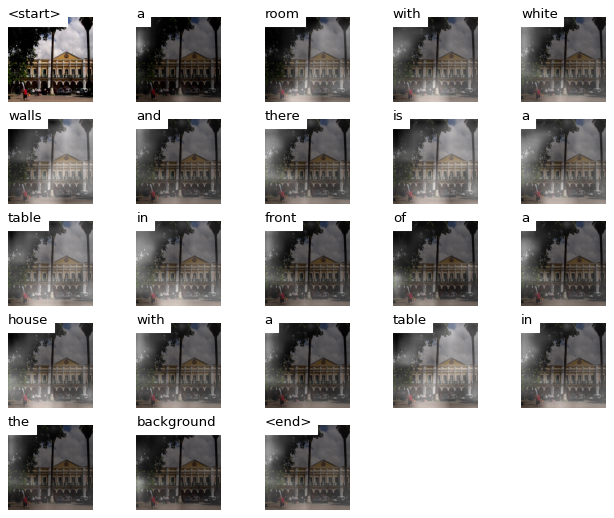


Generating captions and attention...:  10%|████▌                                         | 1/10 [00:03<00:31,  3.48s/it]

../data/iaprtc12/images/00/712.jpg


/tmp/ipykernel_15099/1667324652.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  plt.imshow(Image.open(img).resize([24 * 38, 24 * 38], Image.LANCZOS))

Generating captions and attention...:  20%|█████████▏                                    | 2/10 [00:04<00:15,  1.97s/it]

../data/iaprtc12/images/00/831.jpg


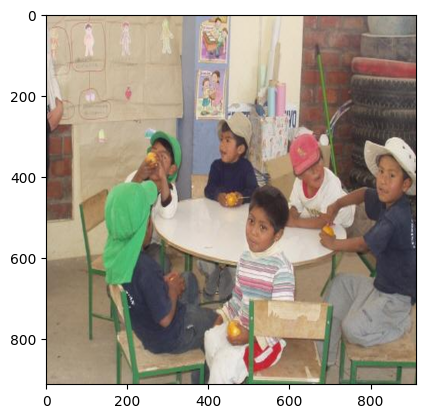

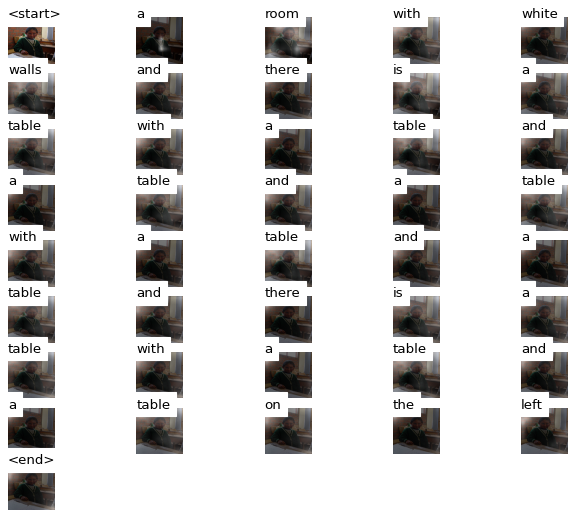


Generating captions and attention...:  30%|█████████████▊                                | 3/10 [00:09<00:22,  3.19s/it]

../data/iaprtc12/images/00/684.jpg


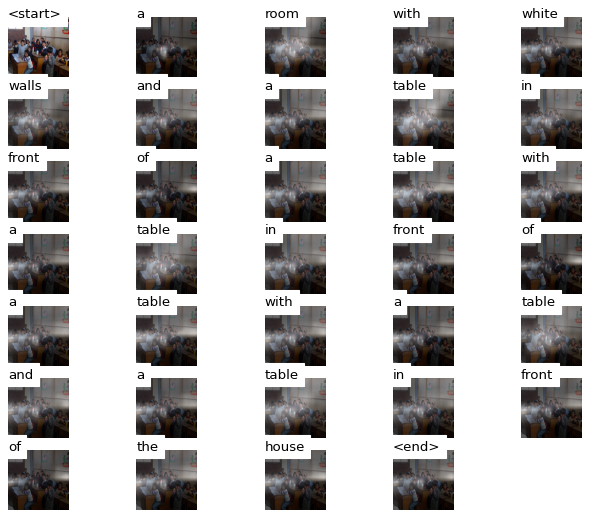


Generating captions and attention...:  40%|██████████████████▍                           | 4/10 [00:13<00:22,  3.70s/it]

../data/iaprtc12/images/00/768.jpg



Generating captions and attention...:  50%|███████████████████████                       | 5/10 [00:14<00:13,  2.79s/it]

../data/iaprtc12/images/00/895.jpg



Generating captions and attention...:  60%|███████████████████████████▌                  | 6/10 [00:15<00:08,  2.11s/it]

../data/iaprtc12/images/00/938.jpg



Generating captions and attention...:  70%|████████████████████████████████▏             | 7/10 [00:16<00:04,  1.64s/it]

../data/iaprtc12/images/00/932.jpg


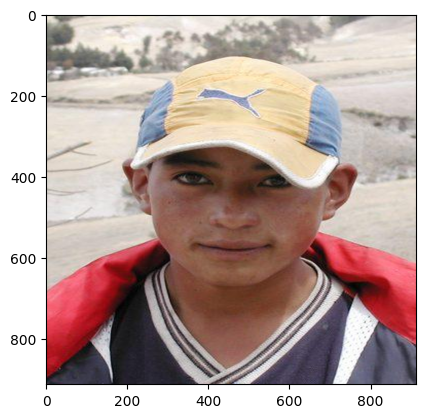

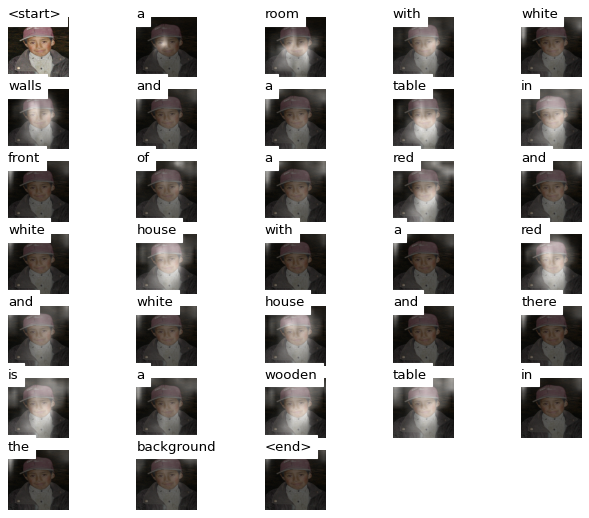


Generating captions and attention...:  80%|████████████████████████████████████▊         | 8/10 [00:20<00:05,  2.57s/it]

../data/iaprtc12/images/00/690.jpg


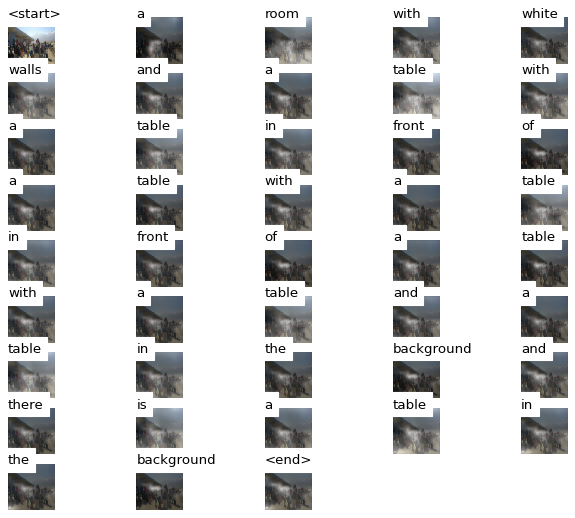


Generating captions and attention...:  90%|█████████████████████████████████████████▍    | 9/10 [00:25<00:03,  3.28s/it]

../data/iaprtc12/images/00/709.jpg


Generating captions and attention...: 100%|█████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]


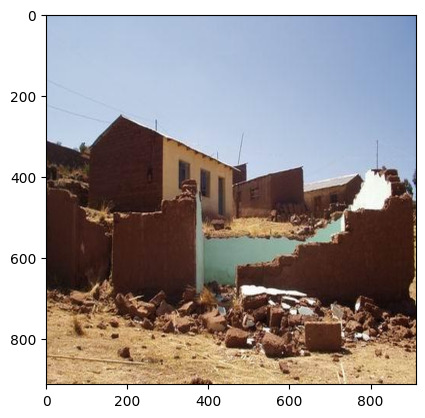

In [34]:
tester = CaptionTester(finetuned_path, word_map_path, device, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN)

# generating captions and descriptions for every image in the test dataloader
# in the future can regulate which ones get generated and displayed with if statements
for batch in tqdm(test_loader, desc='Generating captions and attention...'):
    img = os.path.join(clef_image_dir, batch['image_paths'][0])
    print(img)
    try:
        tester.test_images(img, hyperparameters['beam_size'], hyperparameters['smooth'])
    except ValueError as e:
        plt.imshow(Image.open(img).resize([24 * 38, 24 * 38], Image.LANCZOS))